# How to create Figure 6


**Paper:** https://arxiv.org/pdf/2002.09301.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from odefilters import odesolver
from odefilters import linearised_odesolver as linsolver
from odefilters import linearised_ode as linode
from odefilters import statespace
from odefilters import inverseproblem as ip
from odefilters.optimisation import minimise_newton, minimise_gd, minimise_rs
from sampling_functions import *

##  Optimisation Experiments

In [2]:
d_guiy = 9

def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, d_guiy, 0)
    evalpts = np.array([h, 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts) * d_guiy).reshape((len(evalpts), d_guiy))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata


In [3]:
# Set Model Parameters
initial_value = np.ones([d_guiy])
initial_time, end_time = 0., 100.
ivpvar = 1e-5    # maybe change this later?
thetatrue = np.array([ 0.1,  0.01,  0.4,  0.01,  0.3, 0.01,  0.7,  0.01,  0.1,  0.2])
ivp = linode.GUiY(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/2000
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=d_guiy))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)



In [4]:
# Make a particle follow a trajectory through the parameter space
niter = 100
init_theta = 1.2 *  np.array([ 0.1,  0.0,  0.4,  0.0,  0.3, 0.0,  0.7,  0.0,  0.1,  0.2]) + np.random.rand(10)*0.01

traj_gd, obj_gd = minimise_gd(iplklhd.potenteval, iplklhd.gradeval, niter, init_theta, lrate=1e-7)
error_gd = np.sqrt(np.sum(np.abs(traj_gd - thetatrue)**2/(thetatrue + 1e-6)**2 ,axis=-1)) # + 1e-6 to avoid division by zero

traj_newton, obj_newton = minimise_newton(iplklhd.potenteval, iplklhd.gradeval, iplklhd.hesseval, niter, init_theta, lrate=1.)
error_newton = np.sqrt(np.sum(np.abs(traj_newton - thetatrue)**2/(thetatrue + 1e-6)**2 ,axis=-1))  # + 1e-6 to avoid division by zero

traj_rs, obj_rs = minimise_rs(iplklhd.potenteval, niter, init_theta, lrate=1e-3)
error_rs = np.sqrt(np.sum(np.abs(traj_rs - thetatrue)**2/(thetatrue + 1e-6)**2 ,axis=-1))

benchmark = np.average(np.sqrt(np.diag(iplklhd.ipvar)))
stdev = np.sqrt(ivpvar)


In [5]:
print("Init:", init_theta)
print("Newton guess:", traj_newton[-1], (np.abs((traj_newton[-1] - thetatrue[:]))/np.abs(thetatrue[:])))
print("Truth:", thetatrue)
print("GD guess:", traj_gd[-1])
print("RS guess:", traj_rs[-1])

print(traj_gd.shape, thetatrue.shape)


Init: [0.12155825 0.00357184 0.48214481 0.00471049 0.36715855 0.00171052
 0.84637196 0.00961565 0.12962458 0.24469741]
Newton guess: [0.09886167 0.00972702 0.40038737 0.00994181 0.2981649  0.0097178
 0.70767844 0.00997887 0.10060118 0.19842566] [0.01138327 0.02729796 0.00096843 0.00581892 0.00611701 0.0282199
 0.01096921 0.00211299 0.00601182 0.00787168]
Truth: [0.1  0.01 0.4  0.01 0.3  0.01 0.7  0.01 0.1  0.2 ]
GD guess: [0.11433769 0.01242222 0.4778127  0.01531076 0.3616411  0.01332628
 0.84223481 0.01223137 0.12884675 0.24256446]
RS guess: [0.11697865 0.01096005 0.4809096  0.00938137 0.37201904 0.00860856
 0.84389843 0.00871717 0.12599868 0.24617483]
(100, 10) (10,)


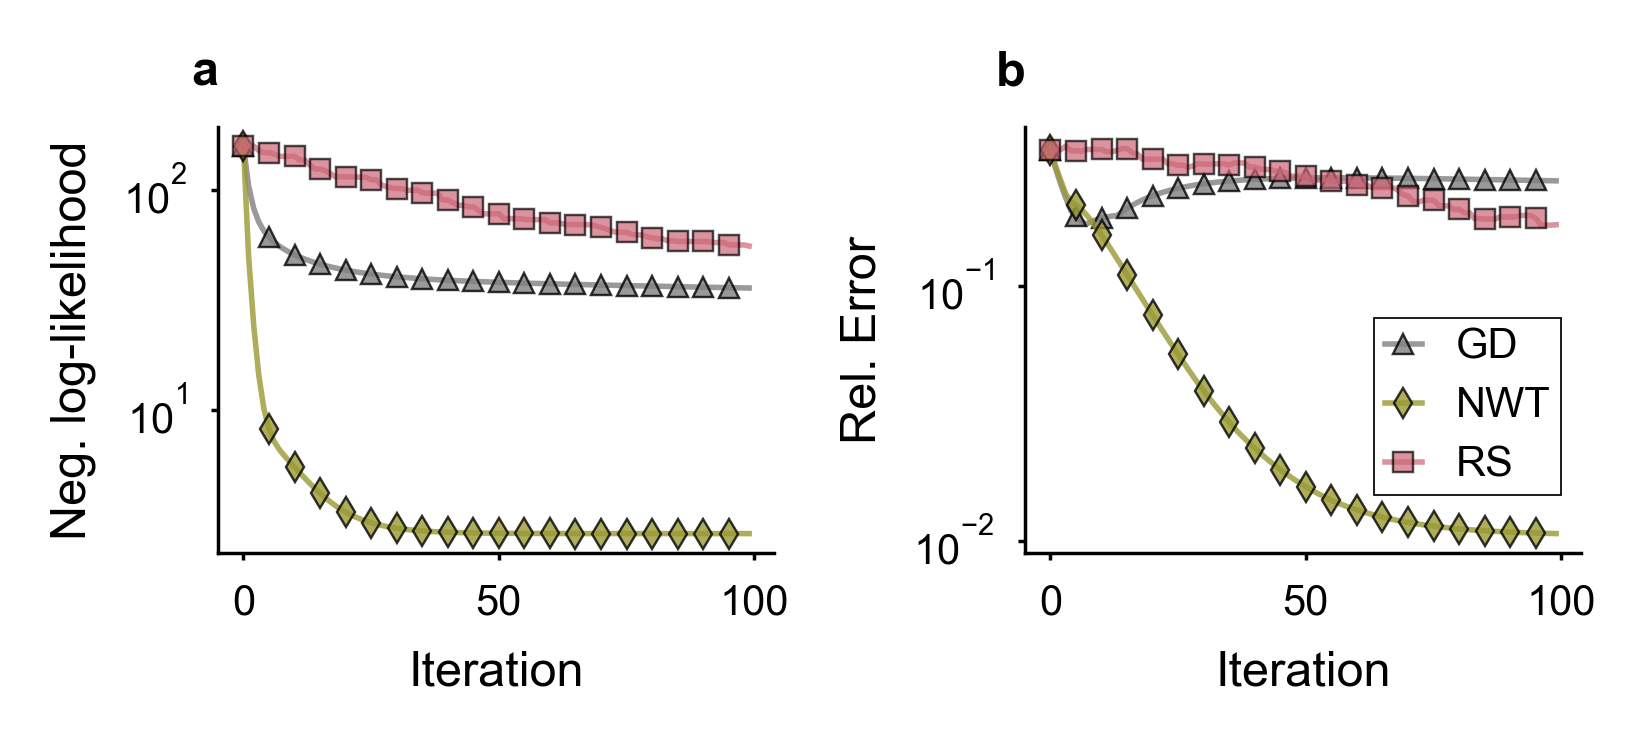

In [6]:

plt.style.use("./icmlstyle.mplstyle")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
# ax1.set_ylim((1e-310, 1e10))
# plt.semilogy(probs_rw, ':', label="RW")
mark_every = 5
ax1.semilogy((obj_gd), markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax1.semilogy((obj_newton), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax1.semilogy((obj_rs), markevery=mark_every, color="#cc6677",   ls="-", marker="s", label="RS", alpha=0.7)
# ax1.set_yticks([1e-300, 1e-200, 1e-100, 1e-0])
# ax1.legend()

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
# plt.semilogy(probs_rw, ':', label="RW")
ax2.semilogy((np.abs((traj_gd - thetatrue[np.newaxis, :]))/np.abs(thetatrue[np.newaxis, :])).mean(axis=1),  markevery=mark_every, color="gray", ls="-", marker="^", label="GD", alpha=0.8)
ax2.semilogy((np.abs((traj_newton - thetatrue[np.newaxis, :]))/np.abs(thetatrue[np.newaxis, :])).mean(axis=1), markevery=mark_every, color="#999933", ls="-", marker="d", label="NWT", alpha=0.8)
ax2.semilogy((np.abs((traj_rs - thetatrue[np.newaxis, :]))/np.abs(thetatrue[np.newaxis, :])).mean(axis=1), markevery=mark_every, color="#cc6677",  ls="-", marker="s", label="RS", alpha=0.7)

# ax1.spines['bottom'].set_position(('outward', 5))
# ax2.spines['bottom'].set_position(('outward', 5))

ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.6))
# plt.figlegend(["GD", "NWT", "RS"], loc="lower center", borderaxespad=-0.5, ncol=3)
ax1.minorticks_off()
ax2.minorticks_off()
ax1.set_title("a", loc="left", fontweight='bold', ha='right')
ax2.set_title("b", loc="left", fontweight='bold', ha='right')

plt.tight_layout()
plt.savefig("./figures/figure6_optim_left")

plt.show()

## Sampling Experiments

In [7]:

def create_data(solver, ivp, thetatrue, stepsize, ivpvar):
    """
    Create artificial data for the inverse problem.
    """
    ivp.params = thetatrue
    tsteps, m, __, __, __ = solver.solve(ivp, stepsize)
    means = odesolver.get_trajectory_ddim(m, d_guiy, 0)
    evalpts = np.array([h, 1., 2., 4., 5., 7., 10., 15., 20., 30., 40., 50., 60., 80., 100.])
    assert(np.prod(np.in1d(evalpts, tsteps))==1), print(evalpts[np.in1d(evalpts, tsteps)==False])
    noise = np.sqrt(ivpvar)*np.random.randn(len(evalpts) * d_guiy).reshape((len(evalpts), d_guiy))
    evalidcs = [list(tsteps).index(evalpt) for evalpt in evalpts]
    data = means[evalidcs] + noise # this is 'wrong' noise
    ipdata = ip.InvProblemData(evalpts, data, ivpvar)
    return ipdata

In [8]:

# Set Model Parameters
initial_value = np.ones([d_guiy])
initial_time, end_time = 0., 100.
ivpvar = 1e-5    # maybe change this later?
thetatrue = np.array([ 0.1,  0.01,  0.4,  0.01,  0.3, 0.01,  0.7,  0.01,  0.1,  0.2])
ivp = linode.GUiY(initial_time, end_time, params=thetatrue, initval=initial_value)

# Set Method Parameters
h_for_data = (end_time - initial_time)/10000
h = (end_time - initial_time)/2000
solver = linsolver.LinearisedODESolver(statespace.IBM(q=1, dim=d_guiy))
ipdata = create_data(solver, ivp, thetatrue, h_for_data, ivpvar)
iplklhd = ip.InvProblemLklhd(ipdata, ivp, solver, h, with_jacob=True)


In [9]:
# Make a particle follow a trajectory through the parameter space
niter = 250
init_theta = 1.2 *  np.array([ 0.1,  0.0,  0.4,  0.0,  0.3, 0.0,  0.7,  0.0,  0.1,  0.2]) + np.random.rand(10)*0.01

samples_lang, probs_lang = langevin(niter, iplklhd, init_theta, stepsize=1., ninits=30)
samples_ham, probs_ham = hamiltonian(niter, iplklhd, init_theta, stepsize=.4, nsteps=4, ninits=30)
samples_rw, probs_rw = randomwalk(niter, iplklhd, init_theta, stepsize=.00003, ninits=30)



Langevin
ratio 0.584


/home/kraemer/Programmes/PYENV/lib/python3.6/site-packages/odefilters/sampling.py:381: RuntimeWarning: covariance is not positive-semidefinite.
  currstate.loghess)


HAMILTONIAN
ratio 0.748
RW
ratio 0.144


In [10]:
print("pHam mode:", samples_ham[np.argmin(probs_ham)])
print("pLang mode:", samples_lang[np.argmin(probs_lang)])
print("RW mode:", samples_rw[np.argmin(probs_rw)])
print("Truth:", thetatrue)
print("Init:", init_theta)


pHam mode: [0.10070521 0.00990572 0.40127641 0.00941251 0.30499183 0.01101169
 0.71314832 0.01071904 0.09520046 0.19059744]
pLang mode: [0.10362768 0.01202734 0.41194449 0.01279855 0.2970185  0.00782537
 0.70432545 0.00904647 0.09820801 0.21181284]
RW mode: [0.10803569 0.01239384 0.44952616 0.01463212 0.34764639 0.01821067
 0.81008083 0.01618856 0.1313528  0.2439472 ]
Truth: [0.1  0.01 0.4  0.01 0.3  0.01 0.7  0.01 0.1  0.2 ]
Init: [0.12780633 0.00796082 0.48573771 0.00352251 0.36716027 0.00304146
 0.84402927 0.00562158 0.12439949 0.2448357 ]


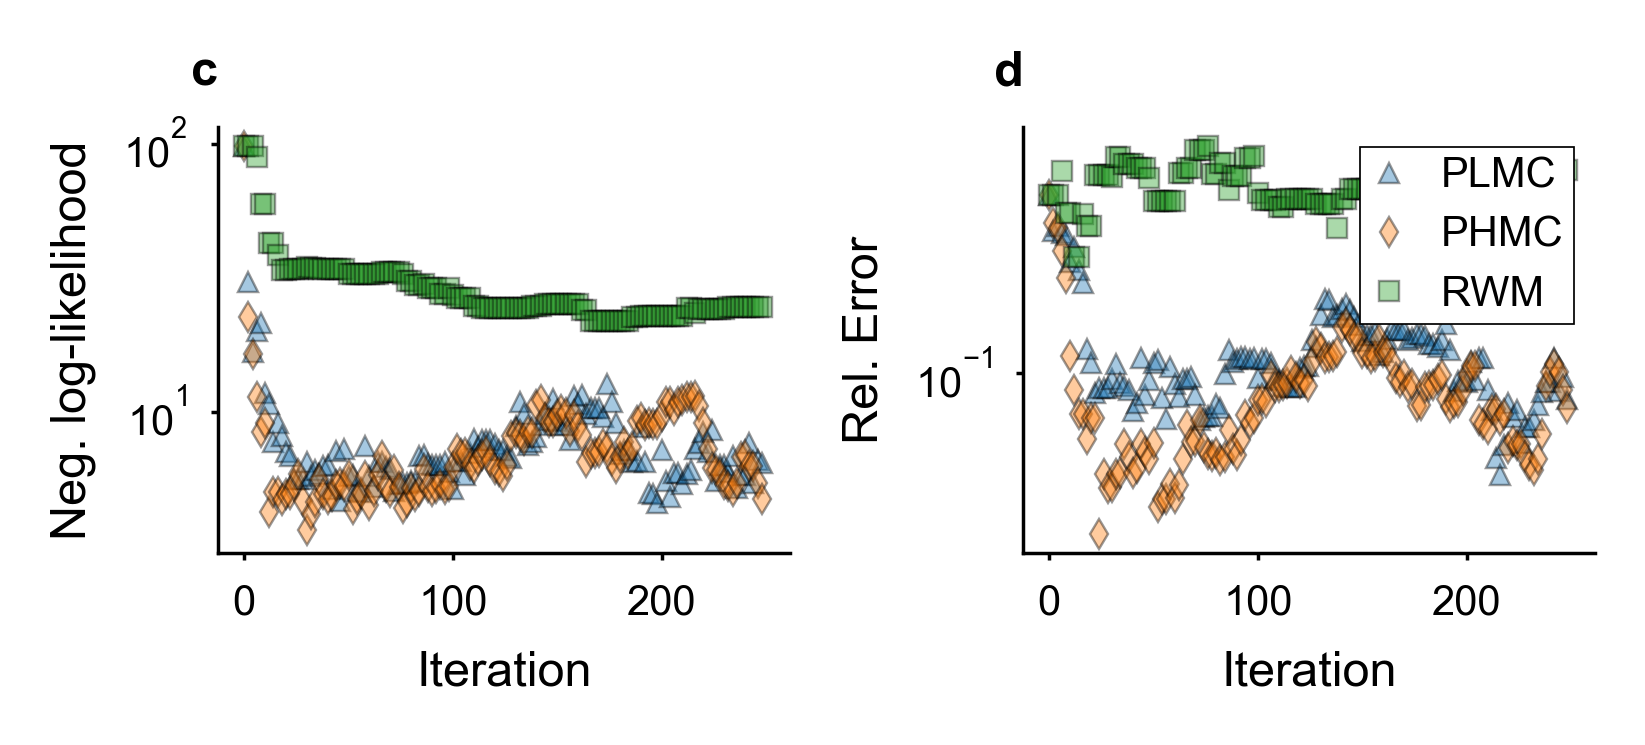

In [11]:
# Plot results
plt.style.use("./icmlstyle.mplstyle")


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Neg. log-likelihood")
# ax1.set_ylim((1e-310, 1e10))
# plt.semilogy(probs_rw, ':', label="RW")
ax1.semilogy((probs_lang), ls='None', marker="^", label="PLMC", alpha=0.4, markevery=2)
ax1.semilogy((probs_ham), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=2)
ax1.semilogy((probs_rw), ls='None', marker="s", label="RWM", alpha=0.4, markevery=2)
# ax1.set_yticks([1e-300, 1e-200, 1e-100, 1e-0])
# ax1.legend()

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Rel. Error")
# plt.semilogy(probs_rw, ':', label="RW")
ax2.semilogy(np.abs((samples_lang - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1),  ls='None', marker="^", label="PLMC", alpha=0.4, markevery=2)
ax2.semilogy(np.abs((samples_ham - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="d", label="PHMC", alpha=0.4, markevery=2)
ax2.semilogy(np.abs((samples_rw - thetatrue[np.newaxis, :])/thetatrue[np.newaxis, :]).mean(axis=1), ls='None', marker="s", label="RWM", alpha=0.4, markevery=2)

# ax1.spines['bottom'].set_position(('outward', 5))
# ax2.spines['bottom'].set_position(('outward', 5))

ax2.legend()
ax1.set_title("c", loc="left", fontweight='bold', ha='right')
ax2.set_title("d", loc="left", fontweight='bold', ha='right')

ax1.minorticks_off()
ax2.minorticks_off()
plt.tight_layout()
plt.savefig("./figures/figure6_sampling_right")

plt.show()